# Solving LunarLander-v2 with Tabular, Deep-Q Network and Policy Gradient Methods (TD Control section)
*  ## Group members:
   *  Mengyang Liu 20198975
   *  Xiaoyao Guo 20175447
   *  Yanan Wang 20114878

## Table of Content: <a class="anchor" id="TOC"></a>
* This table of content only works for offline.
* If this is opened on Colab, consider the generated table of content on the left.

<br>

### [Initialize and Setting up Environment](#ENV)
* [Initialization](#init)
* [LunarLander-v2](#lunarlander)

<br>

### [Setting up Discretizers](#disc)
* [Uniform discretization](#unidisc)
* [Manual discretization](#mandisc)

<br>

### [SARSA](#SARSA)
* [Grid search](#sarsags)
* [SARSA with Uniform discretization](#sarsauni)
* [SARSA with Manual discretization](#sarsaman)

<br>

### [Q-learning](#Qlearning)
* [Grid search](#qlearninggs)
* [Q-learning with Uniform discretization](#qlearninguni)
* [Q-learning with Manual discretization](#qlearningman)

<br>

### [Conclusion](#conc)

## Initialize and Setting up Environment  <a class="anchor" id="ENV"></a>

<br>

*   [To Table of Contents](#TOC)

### Initialization <a class="anchor" id="init"></a>
*  Two custom packages are used:
   *  **"custom_animation.py"**: we only use method `animate_one_episode(env, policy)` to play one episode of LunarLander by the given policy and show the animation.
      *  Detailed explanation about this method will be shown later.
      *  Require `matplotlib` and `opencv-python`.
   *  **"custom_tdcontrol.py"**: our implementation of TDControl, including tabular SARSA and Q-learning.
      *  An API of it can be seen in **"custom_tdcontrol_API.md"**.

In [ ]:
%matplotlib notebook
import numpy as np
import gym
from IPython.display import HTML
import matplotlib.pyplot as plt

# Import custom packages
# If running on Colab, we need to specify the path of this notebook
import sys
if "google.colab" in sys.modules:
    # Set this to the directory of this file in Google Drive
    notebook_path = '/content/drive/MyDrive/CISC 474/code' 
    sys.path.append(notebook_path)
    sys.path.append(notebook_path+'/models')
    sys.path.append(notebook_path+'/models/clips')
    from google.colab import files
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = notebook_path
else:
    root_path = '.'

import custom_animation as ani
import custom_tdcontrol as td

# Ignore deprecation warnings:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Mounted at /content/drive


In [ ]:
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 138 kB/s 
     |████████████████████████████████| 374 kB 75.6 MB/s 
     |████████████████████████████████| 1.8 MB 44.1 MB/s 
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


*   Run the following code if not on Colab for visualization.

In [ ]:
pip install opencv-python

*   A function to plot learning curves.

In [ ]:
def plot_learning_curve(epoch_lists, epoch_size = 500, legend = None, title = None, x_label = "episodes", y_label = "avg reward per epoch", size = 1):
    for i in range(len(epoch_lists)):
        x = [(j+1)*epoch_size for j in range(len(epoch_lists[i]))]
        if not legend:
            plt.plot(x, epoch_lists[i])
        else:
            plt.plot(x, epoch_lists[i], label = legend[i])
            
    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title("Learning curves for each training episode", fontsize=17)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.figure(figsize=[size*6.4, size*4.8])

*   A function to perform grid search on hyperparameters.
  *  `epsilons`: a list of choices of $\varepsilon$ for $\varepsilon$-greedy.
  *  `alphas`: a list of choices of learning rate $\alpha$.
  *  `env`: environment to solve
  *  Other paramters:
     *  `algorithm`, `disc` are consistent to those in `TDControl` class initializer from "custom_tdcontrol.py".
     *  `env`, `max_epsiode_number`, `epoch_size`, `tol`, `tol_epoch` are the consistent to those in `train()` method from "custom_tdcontrol.py".
  
  <br>

  *  Return a tuple of below 3 elements:
     *  `model`: a list of models trained in the grid search.
     *  `step_lists`: The lists of average steps taken in episodes per epoch for each model.
     *  `reward_lists`: The lists of average total reward obtained in episodes per epoch for each model.
     *  `change_lists`: The lists of policy changes between before and after every epoch for each model.

In [ ]:
def grid_search(epsilons, alphas, env, algorithm="Q-learning", disc = None, max_episode_number=150000, epoch_size = 500, tol = 0.1, tol_epoch = 6):
  models = []
  step_lists = []
  reward_lists = []
  change_lists = []
  for i in range(len(epsilons)):  
      for j in range(len(alphas)):
          model = td.TDControl(algorithm=algorithm, epsilon = epsilons[i], alpha = alphas[j], disc = disc)
          model_step_list, model_reward_list, model_change_list = model.train(env, max_episode_number, epoch_size, tol, tol_epoch, verbose=False)
          models.append(model)
          step_lists.append(model_step_list)
          reward_lists.append(model_reward_list)
          change_lists.append(model_change_list)
  
  return models, step_lists, reward_lists, change_lists

### LunarLander-v2 <a class="anchor" id="lunarlander"></a>
*   Brief description of the environment:
  *   Objective: Land the lander smoothly on the landing pad.
  *   Action: 4 in total. No firing or fire 1 of 3 engines.
  *   States: 8 entries in total, **first 6 are continuous** and last 2 are boolean.
  *   Reward: Solving the game is +200. Going closer/far away from the landing pad will receive positive/negative reward.
*   Explainations of the parameters:
  *   `continuous`: if `True`, the timestep of the environment will be continuous. For simplicity, we use the discrete version.
  *   `gravity`: the gravity in landing, must be negative for solving.
  *   **`enable_wind`**: if `True`, the environment contains wind to affect the lander. **The wind stays the same within an episode, but stochastically generated each time**.
    *  We will disenable wind for tabular methods.
  *   `wind_power`: used to generate the wind and decides the affect on velocity of the lander.
  *   `turbulence_power`: used to generate the wind and decides the affect on angular velocity of the lander.
*   Detailed explanation can be seen in our report or the [official website](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) in gym of this environment.

In [ ]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)

*   Show an example space and an animation played by a constant policy

In [ ]:
print(env.reset(seed=42))

[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


*  `animate_one_episode(env, model, seed=None, n_max_steps=400, interval=30, position=(10,380), size=1.2, weight=2)`:
  *  `env`: the environment
  *  `model`: the policy to determine actions, must support `predict()` method.
  *  `seed`: random seed to use for environment.
  *  `n_max_steps`: maximum steps allowed for each episode.
  *  `interval`: miliseconds between images.
  *  `position`: position to put the annotation texts
  *  `size`: size of the annotation texts
  *  `weight`: thickness of the annotation texts

In [ ]:
class constant_policy:
  def __init__(self, action):
    self.action = action
  def predict(self, action):
    return self.action

# Full call:
# anim = ani.animate_one_episode(env, model, seed=None, n_max_steps=400, interval=30, position=(10,380), size=1.2, weight=2)
anim = ani.animate_one_episode(env, constant_policy(0))
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

*  **Allow displaying figures in Colab.**
   *  Run this after the animation for cleaner outputs.

In [ ]:
if "google.colab" in sys.modules:
  %matplotlib inline

## Setting up Discretizers  <a class="anchor" id="disc"></a>
*   To apply tabular methods on states that contains continuous observations, we need to discretize them.

<br>

*   [To Table of Contents](#TOC)

### Uniform Discretization <a class="anchor" id="unidisc"></a>
*  A naive approach is to discretize the continuous values into bins of same sizes.
*  6 continuous states in total. To make the size of the Q-table to be reasonable, we choose 4 bins for each value.
   *  4 bins and 4 actions will result the Q-table in size: $4^6\times 2^2\times 4 = 65536 $ entries.
   *  3 bins will give 11664 entries and 5 bins will give 250000 entries. They are either too small or too big.

In [ ]:
def uniform_disc(obs):
  upper_bound = [1.5,1.5,5,5,3.14,5]
  lower_bound = [-1.5,-1.5,-5,-5,-3.14,-5]
  bin_num = 4
  disc_obs = obs.copy()
  for i in range(6):
    # Handle the BUG in the ENVIRONMENT, angle can exceed upper bound
    if i == 4: # Locate angle index
      pi = 3.1415927
      while obs[i] >= upper_bound[i]:
        obs[i] -= 2*pi
      while obs[i] <= lower_bound[i]:
        obs[i] += 2*pi

    # Handle the BUG in the ENVIRONMENT, other values can exceed bounds
    if not i == 4: # Locate other index
      if obs[i] > upper_bound[i]:
        obs[i] = upper_bound[i]
      if obs[i] < lower_bound[i]:
        obs[i] = lower_bound[i]

    # Discretize
    bin_size = (upper_bound[i] - lower_bound[i]) / bin_num
    disc_obs[i] = (obs[i] - lower_bound[i]) // bin_size

    # Occur at dividing pi/4
    if int(disc_obs[i]) == -1:
      disc_obs[i] = 0

    # Handle endpoint values
    if int(disc_obs[i]) == bin_num:
      disc_obs[i] -= 1

  return disc_obs.astype(np.int32).tolist()

### Manual Discretization <a class="anchor" id="mandisc"></a>
*  Motivation: some values are sensitive at some intervals.
   *  Ex: at heights close to the landing pad, precise control is needed so we want our policy to  focus on that.
   *  This approach also incorporates existing knowledge and should accelerate the learning.
*  2 changes are made from the previous uniform discretizer:
   *   Horizontal coordinate: [-1.5, -0.15), [-0.15, 0.15), [0.15,1.5]
   *   Vertical coordinate: [-1.5, 0.1), [0.1, 0.35), [0.35, 1.5]
*  Visualization of Manual bin:
*  
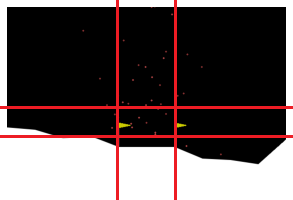

In [ ]:
def manual_disc(obs):
  upper_bound = [1.5,1.5,5,5,3.14,5]
  lower_bound = [-1.5,-1.5,-5,-5,-3.14,-5]
  bin_num = 4
  disc_obs = obs.copy()
  # Horizontal
  if obs[0] >= 0.15:
    disc_obs[0] = 2
  elif obs[0] >= -0.15:
    disc_obs[0] = 1
  else:
    disc_obs[0] = 0

  # Vertical
  if obs[1] >= 0.35:
    disc_obs[1] = 2
  elif obs[1] >= 0.1:
    disc_obs[1] = 1
  else:
    disc_obs[1] = 0

  # Others
  for i in range(2,6):
    # Handle the BUG in the ENVIRONMENT, angle can exceed upper bound
    if i == 4: # Locate angle index
      pi = 3.1415927
      while obs[i] >= upper_bound[i]:
        obs[i] -= 2*pi
      while obs[i] <= lower_bound[i]:
        obs[i] += 2*pi

    # Handle the BUG in the ENVIRONMENT, other values can exceed bounds
    if not i == 4: # Locate other index
      if obs[i] > upper_bound[i]:
        obs[i] = upper_bound[i]
      if obs[i] < lower_bound[i]:
        obs[i] = lower_bound[i]

    # Discretize
    bin_size = (upper_bound[i] - lower_bound[i]) / bin_num
    disc_obs[i] = (obs[i] - lower_bound[i]) // bin_size

    # Occur at dividing pi/4
    if int(disc_obs[i]) == -1:
      disc_obs[i] = 0

    # Handle endpoint values
    if int(disc_obs[i]) == bin_num:
      disc_obs[i] -= 1

  return disc_obs.astype(np.int32).tolist()

## SARSA  <a class="anchor" id="SARSA"></a>
*   In this section, we will explore SARSA. 
    *   First, we find the best hyperparamters with grid search.
    *   Second, we train it using uniform discretizer.
    *   Third, we decrease the exploration to see if better results are given.
    *   Finally, we use manual discretizer to see if it can improve.

<br>

*   [To Table of Contents](#TOC)

### Grid Search <a class="anchor" id="sarsags"></a>

*   Set up choices of hyperparamters.

In [ ]:
epsilons = [0.1, 0.2, 0.5]
alphas = [0.1, 0.5, 1]
const_legends = []
for i in range(len(epsilons)):
  for j in range(len(alphas)):
    const_legends.append("e="+str(epsilons[i])+", a="+str(alphas[j]))

*   Perform grid search.

In [ ]:
sarsa_c_models, sarsa_c_step_lists, sarsa_c_reward_lists, sarsa_c_change_lists = grid_search(epsilons=epsilons, alphas=alphas, env=env, algorithm="SARSA", disc = uniform_disc, 
                                                  max_episode_number=10000, epoch_size=100, tol=0, tol_epoch=1)

Done
Done
Done
Done
Done
Done
Done
Done
Done


*  Visualization of the results:

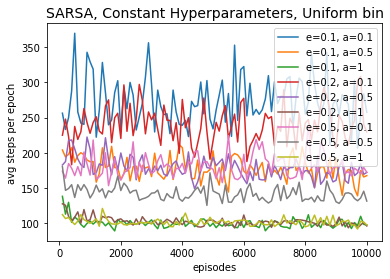

<Figure size 2304x1728 with 0 Axes>

In [ ]:
plot_learning_curve(sarsa_c_step_lists, epoch_size = 100, legend = const_legends, title = "SARSA, Constant Hyperparameters, Uniform bin", 
          x_label = "episodes", y_label = "avg steps per epoch", size = 5)

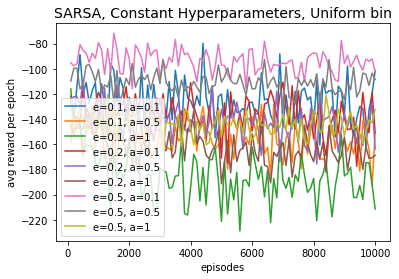

<Figure size 2304x1728 with 0 Axes>

In [ ]:
plot_learning_curve(sarsa_c_reward_lists, epoch_size = 100, legend = const_legends, title = "SARSA, Constant Hyperparameters, Uniform bin", 
          x_label = "episodes", y_label = "avg reward per epoch", size = 5)

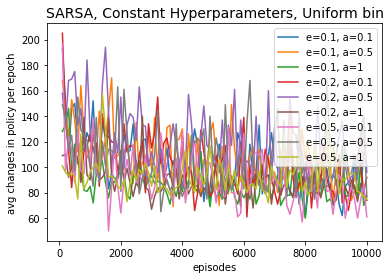

<Figure size 2304x1728 with 0 Axes>

In [ ]:
plot_learning_curve(sarsa_c_change_lists, epoch_size = 100, legend = const_legends, title = "SARSA, Constant Hyperparameters, Uniform bin", 
          x_label = "episodes", y_label = "avg changes in policy per epoch", size = 5)

*  Try decaying explorations

### SARSA with Uniform Discretization <a class="anchor" id="sarsauni"></a>

In [ ]:
sarsa = td.TDControl(algorithm="SARSA", epsilon = 0.5, alpha = 0.1, disc = uniform_disc)
sarsa_step_list, sarsa_reward_list, sarsa_change_list = sarsa.train(env=env, max_episode_number=40000, epoch_size=1000, tol=0, tol_epoch=1, verbose=True)

episode: 1000, avg episode steps: 176.8200, avg episode reward: -99.7277, abs reward diff: 99.7277, changed policies: 373
episode: 2000, avg episode steps: 180.1510, avg episode reward: -88.6773, abs reward diff: 11.0505, changed policies: 304
episode: 3000, avg episode steps: 179.1000, avg episode reward: -90.2826, abs reward diff: 1.6053, changed policies: 292
episode: 4000, avg episode steps: 183.0920, avg episode reward: -94.1967, abs reward diff: 3.9142, changed policies: 274
episode: 5000, avg episode steps: 180.5450, avg episode reward: -94.8700, abs reward diff: 0.6733, changed policies: 291
episode: 6000, avg episode steps: 183.1400, avg episode reward: -93.0753, abs reward diff: 1.7947, changed policies: 276
episode: 7000, avg episode steps: 187.7990, avg episode reward: -92.2424, abs reward diff: 0.8329, changed policies: 270
episode: 8000, avg episode steps: 188.2190, avg episode reward: -92.8752, abs reward diff: 0.6329, changed policies: 301
episode: 9000, avg episode ste

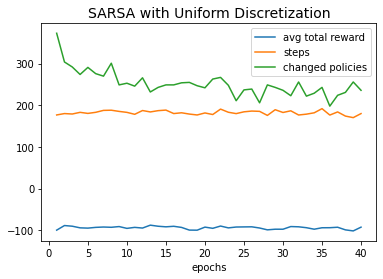

<Figure size 460.8x345.6 with 0 Axes>

In [ ]:
plot_learning_curve([sarsa_reward_list, sarsa_step_list, sarsa_change_list], epoch_size = 1, legend = ["avg total reward", "steps", "changed policies"], title = "SARSA with Uniform Discretization", x_label = "epochs", y_label = "", size = 1)

### SARSA with Manual Discretization <a class="anchor" id="sarsaman"></a>

In [ ]:
sarsa2 = td.TDControl(algorithm="SARSA", epsilon = 0.5, alpha = 0.1, disc = manual_disc)
sarsa2_step_list, sarsa2_reward_list, sarsa2_change_list = sarsa.train(env=env, max_episode_number=40000, epoch_size=1000, tol=0, tol_epoch=1, verbose=True)

episode: 1000, avg episode steps: 188.1640, avg episode reward: -91.7109, abs reward diff: 91.7109, changed policies: 229
episode: 2000, avg episode steps: 187.0440, avg episode reward: -91.8052, abs reward diff: 0.0943, changed policies: 236
episode: 3000, avg episode steps: 186.9660, avg episode reward: -92.2209, abs reward diff: 0.4157, changed policies: 242
episode: 4000, avg episode steps: 176.3880, avg episode reward: -94.8962, abs reward diff: 2.6753, changed policies: 224
episode: 5000, avg episode steps: 191.3740, avg episode reward: -91.8813, abs reward diff: 3.0150, changed policies: 245
episode: 6000, avg episode steps: 173.9630, avg episode reward: -96.3838, abs reward diff: 4.5025, changed policies: 195
episode: 7000, avg episode steps: 180.0150, avg episode reward: -98.6691, abs reward diff: 2.2853, changed policies: 255
episode: 8000, avg episode steps: 180.6580, avg episode reward: -100.3054, abs reward diff: 1.6363, changed policies: 252
episode: 9000, avg episode ste

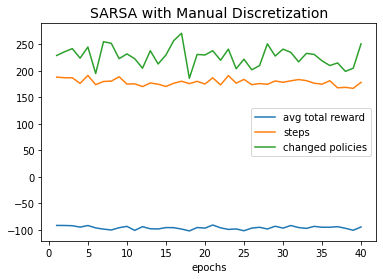

<Figure size 460.8x345.6 with 0 Axes>

In [ ]:
plot_learning_curve([sarsa2_reward_list, sarsa2_step_list, sarsa2_change_list], epoch_size = 1, legend = ["avg total reward", "steps", "changed policies"], title = "SARSA with Manual Discretization", x_label = "epochs", y_label = "", size = 1)

## Q-learning  <a class="anchor" id="Qlearning"></a>

<br>

*   [To Table of Contents](#TOC)

### Grid Search <a class="anchor" id="qlearninggs"></a>

*  Set up choices of hyperparameters (same as in SARSA).

In [ ]:
epsilons = [0.1, 0.2, 0.5]
alphas = [0.1, 0.5, 1]
const_legends = []
for i in range(len(epsilons)):
  for j in range(len(alphas)):
    const_legends.append("e="+str(epsilons[i])+", a="+str(alphas[j]))

*   Perform grid search.

In [ ]:
q_c_models, q_c_step_lists, q_c_reward_lists, q_c_change_lists = grid_search(epsilons=epsilons, alphas=alphas, env=env, algorithm="Q-learning", disc = uniform_disc, 
                                           max_episode_number=10000, epoch_size=100, tol=0, tol_epoch=1)

Done
Done
Done
Done
Done
Done
Done
Done
Done


*  Visualization of the results:

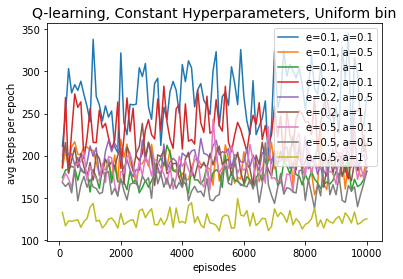

<Figure size 2304x1728 with 0 Axes>

In [ ]:
plot_learning_curve(q_c_step_lists, epoch_size = 100, legend = const_legends, title = "Q-learning, Constant Hyperparameters, Uniform bin", 
          x_label = "episodes", y_label = "avg steps per epoch", size = 5)

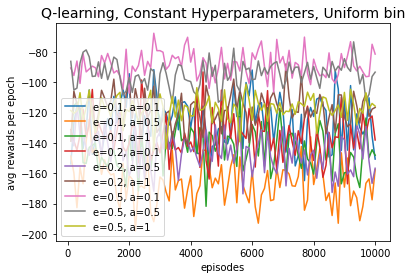

<Figure size 2304x1728 with 0 Axes>

In [ ]:
plot_learning_curve(q_c_reward_lists, epoch_size = 100, legend = const_legends, title = "Q-learning, Constant Hyperparameters, Uniform bin", 
          x_label = "episodes", y_label = "avg rewards per epoch", size = 5)

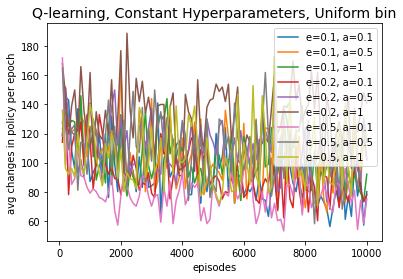

<Figure size 2304x1728 with 0 Axes>

In [ ]:
plot_learning_curve(q_c_change_lists, epoch_size = 100, legend = const_legends, title = "Q-learning, Constant Hyperparameters, Uniform bin", 
          x_label = "episodes", y_label = "avg changes in policy per epoch", size = 5)

*  Try decaying explorations

### Q-learning with Uniform Discretization <a class="anchor" id="qlearninguni"></a>

In [ ]:
qlearning = td.TDControl(algorithm="Q-learning", epsilon = 0.5, alpha = 0.1, disc = uniform_disc)
q_step_list, q_reward_list, q_change_list = qlearning.train(env=env, max_episode_number=40000, epoch_size=1000, tol=0, tol_epoch=1, verbose=True)

episode: 1000, avg episode steps: 169.2310, avg episode reward: -94.4157, abs reward diff: 94.4157, changed policies: 341
episode: 2000, avg episode steps: 181.1480, avg episode reward: -89.1262, abs reward diff: 5.2895, changed policies: 256
episode: 3000, avg episode steps: 189.7780, avg episode reward: -82.7324, abs reward diff: 6.3938, changed policies: 252
episode: 4000, avg episode steps: 180.5570, avg episode reward: -85.6653, abs reward diff: 2.9329, changed policies: 245
episode: 5000, avg episode steps: 185.8290, avg episode reward: -86.0468, abs reward diff: 0.3816, changed policies: 249
episode: 6000, avg episode steps: 185.7320, avg episode reward: -88.1340, abs reward diff: 2.0872, changed policies: 235
episode: 7000, avg episode steps: 183.8320, avg episode reward: -91.3799, abs reward diff: 3.2458, changed policies: 210
episode: 8000, avg episode steps: 181.4450, avg episode reward: -86.5957, abs reward diff: 4.7841, changed policies: 257
episode: 9000, avg episode step

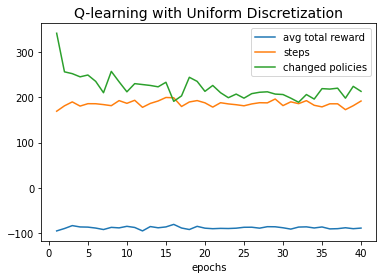

<Figure size 460.8x345.6 with 0 Axes>

In [ ]:
plot_learning_curve([q_reward_list, q_step_list, q_change_list], epoch_size = 1, legend = ["avg total reward", "steps", "changed policies"], title = "Q-learning with Uniform Discretization", x_label = "epochs", y_label = "", size = 1)

In [ ]:
qlearning.save('q_uniform_bin.csv')

### Q-learning with Manual Discretization <a class="anchor" id="qlearningman"></a>

In [ ]:
qlearning2 = td.TDControl(algorithm="Q-learning", epsilon = 0.5, alpha = 0.1, disc = manual_disc)
q2_step_list, q2_reward_list, q2_change_list = qlearning2.train(env=env, max_episode_number=40000, epoch_size=1000, tol=0, tol_epoch=1, verbose=True)

episode: 1000, avg episode steps: 181.1720, avg episode reward: -81.4356, abs reward diff: 81.4356, changed policies: 291
episode: 2000, avg episode steps: 181.1010, avg episode reward: -82.4450, abs reward diff: 1.0094, changed policies: 215
episode: 3000, avg episode steps: 184.1250, avg episode reward: -83.9022, abs reward diff: 1.4572, changed policies: 206
episode: 4000, avg episode steps: 185.5960, avg episode reward: -87.0865, abs reward diff: 3.1843, changed policies: 189
episode: 5000, avg episode steps: 192.7000, avg episode reward: -81.6272, abs reward diff: 5.4593, changed policies: 188
episode: 6000, avg episode steps: 187.4000, avg episode reward: -87.2608, abs reward diff: 5.6336, changed policies: 199
episode: 7000, avg episode steps: 178.4230, avg episode reward: -85.6540, abs reward diff: 1.6068, changed policies: 190
episode: 8000, avg episode steps: 180.1580, avg episode reward: -80.8386, abs reward diff: 4.8154, changed policies: 191
episode: 9000, avg episode step

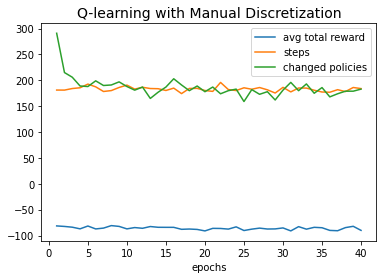

<Figure size 460.8x345.6 with 0 Axes>

In [ ]:
plot_learning_curve([q2_reward_list, q2_step_list, q2_change_list], epoch_size = 1, legend = ["avg total reward", "steps", "changed policies"], title = "Q-learning with Manual Discretization", x_label = "epochs", y_label = "", size = 1)

In [ ]:
qlearning2.save('q_manual_bin.csv')

## Conclusion <a class="anchor" id="conc"></a>

<br>

*   [To Table of Contents](#TOC)

*  None of the above tabular method (SARSA/Q-learning) or discretization (Uniform/Manual) solves the environment.
*  Algorithms that support more complexity is required.